In [45]:
import tensorflow as tf
from tensorflow.contrib import seq2seq
import helper
from data_generator import CoupletsDataGenerator
import numpy as np
from matplotlib import pylab as plt

%matplotlib inline

In [2]:
! pwd

/Users/zhangshulin_work/Desktop/AI-Play/Git/couplets/tensorflow_imp


In [3]:
%cd ..

/Users/zhangshulin_work/Desktop/AI-Play/Git/couplets


In [4]:
vocab_size, index2word, word2index, train_set, dev_set, test_set = helper.process_dataset(vocab_size=1000)

vocab_size: 1000
train_set shape: (766491, 52)
dev_set shape: (4000, 40)
test_set shape: (4000, 43)


In [5]:
train_seq_len = train_set.shape[-1]
dev_seq_len = dev_set.shape[-1]
test_seq_len = test_set.shape[-1]

In [6]:
train_gen = CoupletsDataGenerator(train_set)
dev_gen = CoupletsDataGenerator(dev_set)
test_gen = CoupletsDataGenerator(test_set)

In [7]:
def build_inputs():
    with tf.name_scope('input_placeholders'):
        input = tf.placeholder(shape=(None, None), dtype=tf.int32, name='input')
        label = tf.placeholder(shape=(None, None), dtype=tf.int32, name='label')
        keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')
        
    return input, label, keep_prob

In [8]:
def build_embeding_layer(input, vocab_size, embeding_dim):
    with tf.name_scope('embeding_layer'):
        embeding_matrix = tf.Variable(tf.random_uniform(shape=(vocab_size, embeding_dim),
                                                        minval=-1, maxval=1, dtype=tf.float32),
                                     name='embeding_matrix')
        embeding = tf.nn.embedding_lookup(embeding_matrix, input, name='embed_lookup')
        
    return embeding

In [9]:
def build_lstm_cell(num_units, num_layers, keep_prob, batch_size):
    with tf.name_scope('lstm_cell'):
        def lstm():
            lstm = tf.nn.rnn_cell.BasicLSTMCell(num_units)
            dropout = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=keep_prob)
            return dropout
        
        cell = tf.nn.rnn_cell.MultiRNNCell([lstm() for _ in range(num_layers)])
        init_zero_state = cell.zero_state(batch_size, tf.float32)

    return cell, init_zero_state

In [10]:
def build_lstm_layer(cell, embed_input, init_state):
    with tf.name_scope('lstm_layer'):
        outputs, final_state = tf.nn.dynamic_rnn(cell, embed_input, initial_state=init_state)
        
    return outputs, final_state

### Hyper-parameters

In [11]:
embeding_dim = 200
lstm_units = 64
lstm_layers = 1
keep_prob = 0.7
batch_size = 128
lr = 0.001
epochs = 1
grad_clip = 5

In [12]:
def build_forward(cell, input, init_state):
    embeding = build_embeding_layer(input, vocab_size, embeding_dim)
    
    outputs, final_state = build_lstm_layer(cell, embeding, init_state)
    
    logits = tf.layers.dense(outputs, vocab_size, name='fc_layer')
    outputs = tf.nn.softmax(logits)
    
    return outputs, logits, final_state

In [13]:
def build_optimizer(cost, lr, grad_clip):
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars), grad_clip)
    train_op = tf.train.AdamOptimizer(lr)
    optimizer = train_op.apply_gradients(zip(grads, tvars))
    
    return optimizer

In [14]:
def cal_accuracy(outputs, labels):
    predicts = tf.cast(tf.argmax(outputs, axis=-1), tf.int32)
    predicts = tf.reshape(predicts, (-1,))
    labels = tf.reshape(labels, (-1,))
    is_rights = tf.equal(predicts, labels)
    accuracy = tf.reduce_mean(tf.cast(is_rights, tf.float32))
    
    return accuracy

In [68]:
def train(gen, lr=lr, batch_size=batch_size, epochs=epochs, 
          keep_prob=keep_prob, print_step=50):
    tf.reset_default_graph()
    
    input_pl, label_pl, keep_prob_pl = build_inputs()
    cell_op, init_zero_state_op = build_lstm_cell(lstm_units, lstm_layers, 
                                                  keep_prob, tf.shape(input_pl)[0])
        
    outputs_op, logits_op, final_state_op = build_forward(cell_op, input_pl,
                                                          init_zero_state_op)
    
    loss_weight_op = tf.where(tf.equal(input_pl, 0), 
                              tf.zeros_like(input_pl, dtype=tf.float32),
                              tf.ones_like(input_pl, dtype=tf.float32))
    cost_op = seq2seq.sequence_loss(logits_op, label_pl, loss_weight_op)
    
    optimizer_op = build_optimizer(cost_op, lr, grad_clip)
    
    accuracy_op = cal_accuracy(outputs_op, label_pl)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    costs = []
    step = 0    
    for X, Y in gen.get_batch(sess, batch_size, epochs):
        feed_dict = {
            input_pl: X,
            label_pl: Y,
            keep_prob_pl: keep_prob
        }
        
        _, cost = sess.run([optimizer_op, cost_op],
                                        feed_dict=feed_dict)
        accuracy = accuracy_op.eval(feed_dict=feed_dict, session=sess)
        
        if step % print_step == 0:
            print('step:{0}--cost:{1:.4f}--accuracy:%{2:.4f}'.format(step, cost, accuracy * 10))
            costs.append(cost)
            
        step += 1
    
    if (step - 1) % print_step != 0:
        print('step:{0}--cost:{1:.4f}--accuracy:%{2:.4f}'.format(step - 1, cost, accuracy * 10))
        
    saver = tf.train.Saver()
    saver.save(sess, './model_save/model.ckpt')
        
    sess.close()
    
    plt.plot(range(0, step, print_step), costs)
    plt.xlabel('step')
    plt.ylabel('cost')

step:0--cost:6.9001--accuracy:%0.0491
step:2--cost:6.7852--accuracy:%0.9430
step:4--cost:6.6592--accuracy:%1.2591
step:6--cost:6.5295--accuracy:%1.2191
step:8--cost:6.3833--accuracy:%1.3063
step:10--cost:6.2392--accuracy:%1.3953
step:12--cost:6.0624--accuracy:%1.4153
step:14--cost:5.8642--accuracy:%1.5534
step:16--cost:5.5687--accuracy:%1.6225
step:18--cost:5.4289--accuracy:%1.4662
step:20--cost:5.1919--accuracy:%1.5098
step:22--cost:4.9868--accuracy:%1.4535
step:24--cost:4.8048--accuracy:%1.5516
step:26--cost:4.5301--accuracy:%1.5352
step:28--cost:4.2840--accuracy:%1.5934
step:30--cost:4.1629--accuracy:%1.5171
step:31--cost:3.9238--accuracy:%1.6061


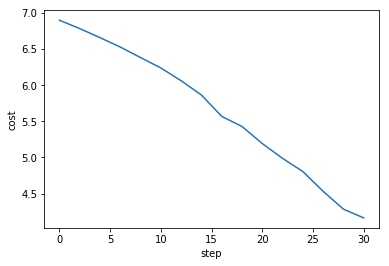

In [69]:
train(test_gen, print_step=2)

In [22]:
def evaluate(gen, batch_size, seq_len):
    tf.reset_default_graph()
    
    input_pl, label_pl, keep_prob_pl = build_inputs()
    cell_op, init_zero_state_op = build_lstm_cell(lstm_units, lstm_layers, 
                                                  keep_prob, tf.shape(input_pl)[0])
        
    outputs_op, logits_op, final_state_op = build_forward(cell_op, input_pl, init_zero_state_op)
    
    loss_weight_op = tf.where(tf.equal(input_pl, 0), 
                              tf.zeros_like(input_pl, dtype=tf.float32),
                              tf.ones_like(input_pl, dtype=tf.float32))
    cost_op = seq2seq.sequence_loss(logits_op, label_pl, loss_weight_op)
    
    accuracy_op = cal_accuracy(outputs_op, label_pl)

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    saver = tf.train.Saver()
    saver.restore(sess, './model_save/model.ckpt')  
    
    step = 0 
    cost = 0
    accuracy = 0
    for X, Y in gen.get_batch(sess, batch_size, epochs):
        feed_dict = {
            input_pl: X,
            label_pl: Y,
            keep_prob_pl: 1
        }
        
        step_cost, step_accuracy = sess.run([cost_op, accuracy_op], feed_dict=feed_dict)
        cost += step_cost
        accuracy += step_accuracy
        
        step += 1
        
    cost = cost / step
    accuracy = accuracy / step
    
    print('cost:{0:.4f} -- accuracy:%{1:.4f}'.format(cost, accuracy * 100))
        
    sess.close()

In [23]:
# print('train set:')
# evaluate(train_gen, batch_size)
print('dev set:')
evaluate(dev_gen, 64, dev_seq_len)

dev set:
INFO:tensorflow:Restoring parameters from ./model_save/model.ckpt
cost:3.8221 -- accuracy:%15.9077


In [32]:
def pick_word_from_top_n(preds, vocab_size, top_n=5):
    p = np.squeeze(preds)
    p[1] = 0
    p[np.argsort(p)[:-top_n]] = 0
    p = p / np.sum(p)
    c = np.random.choice(vocab_size, 1, p=p)[0]
    
    return c

In [37]:
def sample(primes_list, top_n=5):
    samples = primes_list.copy()
    
    tf.reset_default_graph()
    
    input_pl, label_pl, keep_prob_pl = build_inputs()
    cell_op, init_zero_state_op = build_lstm_cell(lstm_units, lstm_layers, 
                                                  tf.cast(tf.shape(input_pl)[0], tf.float32), 1)
    init_state_op = init_zero_state_op
    outputs_op, _, final_state_op = build_forward(cell_op, input_pl, init_state_op)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    saver = tf.train.Saver()
    saver.restore(sess, './model_save/model.ckpt') 
    
    init_state = sess.run(init_state_op)
    
    for word in primes_list:
        x = np.zeros((1, 1), dtype=np.int32)
        x[0, 0] = word2index.get(word, 1)
        
        feed_dict = {
            input_pl: x,
            keep_prob_pl: 1,
            init_state_op: init_state
        }
        
        outputs, final_state = sess.run([outputs_op, final_state_op], feed_dict=feed_dict)
        init_state = final_state
        
    pick_word_index = pick_word_from_top_n(outputs, vocab_size, top_n)
    samples.append(index2word[pick_word_index])
    
    while True:
        x = np.zeros((1, 1), dtype=np.int32)
        x[0, 0] = pick_word_index
        
        feed_dict = {
            input_pl: x,
            keep_prob_pl: 1,
            init_state_op: init_state
        }
        
        outputs, final_state = sess.run([outputs_op, final_state_op], feed_dict=feed_dict)
        init_state = final_state
        
        pick_word_index = pick_word_from_top_n(outputs, vocab_size, top_n)
        pick_word = index2word[pick_word_index]
        samples.append(pick_word)
    
        if pick_word == '。':
            break
            
    sess.close()
    
    return ''.join(samples)

In [38]:
sample(primes_list=['明天'], top_n=5)

INFO:tensorflow:Restoring parameters from ./model_save/model.ckpt


'明天月。'

In [39]:
import jieba

In [40]:
def predict(prime_sentence, top_n=5):
    primes_list = list(jieba.cut(prime_sentence))
    return sample(primes_list, top_n)

In [41]:
predict('床前明月光')

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/n2/ndjtbc452y3c2qqh7g4wbly80000gn/T/jieba.cache
Loading model cost 0.726 seconds.
Prefix dict has been built succesfully.


INFO:tensorflow:Restoring parameters from ./model_save/model.ckpt


'床前明月光，。'